# Inflation Forecast
Evidence suggests that the processes producing inflation change over time. The data relevant to determine the inflation rate during recessions may not be influential during growth periods. That is, the model might change with Business Cycles. Since it is not straightforward to identify at which point of a cycle the economy is currently on, this hinders the performance of structural approaches. And increase the time necessary to train data-driven multivariate models. Thus, an univariate, nonlinear model seems to be a good starting point.
Long Short-Term Memory (LSTM) is a Recurrent Neural Network (RNN) designed to learn long sequences o data. It does not rely on pre-specified structures or windows - a good fit for forecasting time series.
The project is [here](https://github.com/olavopoletti/Inflation_Forecast.git).


In [1]:
# Imports
import warnings
warnings.filterwarnings("ignore")

import os.path
from pathlib import Path
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.models import Sequential, save_model, load_model
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
from sklearn.metrics import mean_squared_error

In [68]:
# Basic layout for graphics
layout = go.Layout(
                    font_family="Segoe UI",
                    font_color="Black",
                    font_size=14,
                    title_font_family="Segoe UI",
                    title_font_color="#A79AFF",
                    title_font_size=18,
                    showlegend=False,
                    margin=dict(b = 10,l= 20,r=10,t=50),
                    xaxis=dict(
                                showgrid=False,
                                gridcolor='DarkGrey',
                                zeroline=False,
                                zerolinecolor='White',
                                zerolinewidth=2,
                                showticklabels=True,
                                ),
                    yaxis=dict(
                                showgrid=True,
                                gridcolor='White',
                                zeroline=True,
                                zerolinecolor='White',
                                zerolinewidth=2,
                                showticklabels=True
                                ),
                    plot_bgcolor='#E3DDD5',
                    paper_bgcolor='#FEFBEA',
                    autosize=True,
                    )

## Data
We are using monthly percentage variations on the Broad National Consumer Price Index available (IPCA) at [BACEN](https://www3.bcb.gov.br/sgspub/localizarseries/localizarSeries.do?method=prepararTelaLocalizarSeries).

In [3]:
# Data Frame
df = pd.read_csv(r"monthlyInflation.csv", sep=";")
df = df.rename(
                columns={
        "433 - Broad National Consumer Price Index (IPCA) - Monthly % var.":
        "IPCA"    
                        }
                )

# Formatting
df = df[df.Date != "Source"]
df["Date"] = df.Date.astype("datetime64[ns]")
df["IPCA" ] = df["IPCA" ].astype("float")
df = df.set_index('Date')
df

,IPCA
Date,
1980-01-01,6.62
1980-02-01,4.62
1980-03-01,6.04
1980-04-01,5.29
1980-05-01,5.70
...,...
2022-04-01,1.06
2022-05-01,0.47
2022-06-01,0.67


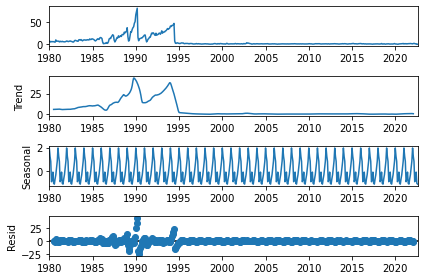

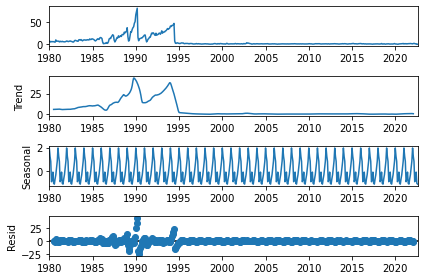

In [4]:
# Decomposing the time series
decomposition = seasonal_decompose(df, model='additive')
decomposition.plot()

There is a sharp contrast between the values before and after the 'Real Plan.' Let's check how the series behave before and after July 1994 separately.

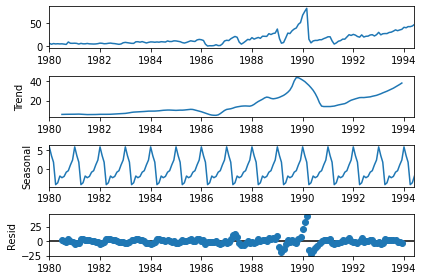

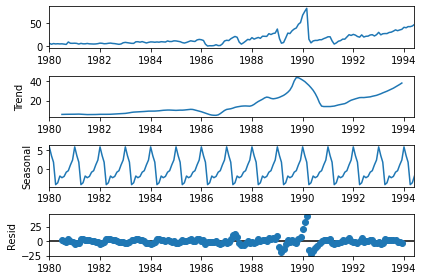

In [5]:
# Decomposition prior to July 1994
decompositionB = seasonal_decompose(
                                    df[df.index < '1994-07-01'],
                                    model='additive'
                                    )
decompositionB.plot()

In [6]:
# Decomposition for data after the 'Real Plan'
decompositionA = seasonal_decompose(
                                    df[df.index >= '1994-07-01'],
                                    model='additive'
                                    )
#decompositionA.plot()

We can see changes in the trend as well on the cycles - besides the magnitude of the value. This suggests that the new plan produced fundamental changes in inflation behavior. Therefore, considering data prior to the stabilization program would create a model with characteristics that no longer reflect the current structure of the Brazilian economy. Since economic policy takes some time to be effective, it is worthwhile considering some buffer periods.

In [6]:
# Filter the dataset to exclude data prior to the 'Real Plan'
df = df[df.index >= '1995-01-01']
df.head()

,IPCA
Date,
1995-01-01,1.70
1995-02-01,1.02
1995-03-01,1.55
1995-04-01,2.43
1995-05-01,2.67


In [7]:
# Checking for Stationarity using Augmented Dickey–Fuller test
def adf_test(data):
    result = adfuller(data.values)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    for key, value in result[4].items():
	    print('\t%s: %.3f' % (key, value))
    if result[1] > 0.01:
        print("Series is not stationary")
    else:
        print("Series is stationary")

adf_test(df)

ADF Statistic: -4.856670
p-value: 0.000042
	1%: -3.451
	5%: -2.871
	10%: -2.572
Series is stationary


In [8]:
# Adding lags to the data. We are considering up to 60 periods prior to the target
col_names = ["T-{}".format(i) for i in range(1, 61)] + ["IPCA"]
def time_steps(data, lag):
	df_temp = data
	columns = [df_temp.shift(i) for i in range(1, lag+1)]
	columns.append(df_temp)
	df_temp = pd.concat(columns, axis=1)
	df_temp.fillna(0, inplace=True)
	df_temp = df_temp.set_axis(col_names, axis=1, inplace=False)
	return df_temp
df_lags = time_steps(df, 60)
df_lags

,T-1,T-2,T-3,T-4,T-5,T-6,T-7,T-8,T-9,T-10,...,T-52,T-53,T-54,T-55,T-56,T-57,T-58,T-59,T-60,IPCA
Date,,,,,,,,,,,,,,,,,,,,,
1995-01-01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.70
1995-02-01,1.70,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.02
1995-03-01,1.02,1.70,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.55
1995-04-01,1.55,1.02,1.70,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.43
1995-05-01,2.43,1.55,1.02,1.70,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-01,1.62,1.01,0.54,0.73,0.95,1.25,1.16,0.87,0.96,0.53,...,0.44,0.28,0.42,0.16,0.19,0.24,-0.23,0.31,0.14,1.06
2022-05-01,1.06,1.62,1.01,0.54,0.73,0.95,1.25,1.16,0.87,0.96,...,0.29,0.44,0.28,0.42,0.16,0.19,0.24,-0.23,0.31,0.47
2022-06-01,0.47,1.06,1.62,1.01,0.54,0.73,0.95,1.25,1.16,0.87,...,0.32,0.29,0.44,0.28,0.42,0.16,0.19,0.24,-0.23,0.67


In [9]:
# Train and test data frames - with the last three years as test
train = df_lags[df_lags.index <= '2019-08-01'].values
test = df_lags[df_lags.index > '2019-08-01'].values

In [10]:
# Scaling the data do match the possible outputs of the activation function.
"""
Since we are using a Hyperbolic Tangent, the data will be scaled to be between -1 and 1.
The scale will be calculated on the training dataset to avoiding biasing de model
"""

# Set up the scaler
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(train.reshape(-1,1))

# Adjust the shape of the data
train = train.reshape(train.shape[0], train.shape[1])
test = test.reshape(test.shape[0], test.shape[1])

# Transform the data
train_scaled = scaler.transform(train.reshape(-1,1))
test_scaled = scaler.transform(test.reshape(-1,1))


In [11]:
train_scaled = np.reshape(
                        train_scaled,
                        (train.shape[0], train.shape[1], -1)
                        )
test_scaled = np.reshape(
                        test_scaled,
                        (test.shape[0], test.shape[1], -1)
                        )

In [12]:
# Predictors and target for the training set
trainX, trainY = train_scaled[:, 0:-1], train_scaled[:, -1]

In [13]:
print(trainX.shape)
trainX

(296, 60, 1)


array([[[-0.71104816],
        [-0.71104816],
        [-0.71104816],
        ...,
        [-0.71104816],
        [-0.71104816],
        [-0.71104816]],

       [[ 0.25212465],
        [-0.71104816],
        [-0.71104816],
        ...,
        [-0.71104816],
        [-0.71104816],
        [-0.71104816]],

       [[-0.13314448],
        [ 0.25212465],
        [-0.71104816],
        ...,
        [-0.71104816],
        [-0.71104816],
        [-0.71104816]],

       ...,

       [[-0.63739377],
        [-0.38810198],
        [-0.28611898],
        ...,
        [-0.5694051 ],
        [-0.70538244],
        [-0.48441926]],

       [[-0.70538244],
        [-0.63739377],
        [-0.38810198],
        ...,
        [-0.38810198],
        [-0.5694051 ],
        [-0.70538244]],

       [[-0.60339943],
        [-0.70538244],
        [-0.63739377],
        ...,
        [-0.47308782],
        [-0.38810198],
        [-0.5694051 ]]])

In [14]:
print(trainY.shape)
trainY

(296, 1)


array([[ 0.25212465],
       [-0.13314448],
       [ 0.16713881],
       [ 0.66572238],
       [ 0.80169972],
       [ 0.5694051 ],
       [ 0.62606232],
       [-0.15014164],
       [-0.15014164],
       [ 0.0878187 ],
       [ 0.12181303],
       [ 0.17280453],
       [ 0.04815864],
       [-0.12747875],
       [-0.51274788],
       [ 0.00283286],
       [-0.01983003],
       [-0.0368272 ],
       [-0.08215297],
       [-0.46175637],
       [-0.62606232],
       [-0.54107649],
       [-0.52974504],
       [-0.44475921],
       [-0.04249292],
       [-0.42776204],
       [-0.42209632],
       [-0.21246459],
       [-0.47875354],
       [-0.40509915],
       [-0.58640227],
       [-0.7223796 ],
       [-0.67705382],
       [-0.58073654],
       [-0.61473088],
       [-0.4674221 ],
       [-0.30878187],
       [-0.45042493],
       [-0.5184136 ],
       [-0.57507082],
       [-0.42776204],
       [-0.69971671],
       [-0.77903683],
       [-1.        ],
       [-0.83569405],
       [-0

## The Model

In [15]:
# The base model
model = Sequential()
model.compile(
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='mean_squared_error',
              metrics=['mean_absolute_error'],
              #run_eagerly=True
              )

# Number of patters to be processed before updating weights
batch_size = 1

# The LSTM input layer
model.add(LSTM(
                120,
                input_shape=(
                              60,
                              1
                              ),
                #return_sequences=True,
                )
          )

# Hidden LSTM layers 
#for i in range(0, 60):
#      model.add(LSTM(120,return_sequences=True))
#model.add(LSTM(120))

# The output layer
model.add(Dense(1))

In [17]:
# Training the model
fit = model.fit(
                trainX,
                trainY,
                validation_data=(trainX, trainY),
                epochs=1000, 
                batch_size=batch_size,
                verbose=0,
                shuffle=False,
                )

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 120)               58560     
                                                                 
 dense (Dense)               (None, 1)                 121       
                                                                 
Total params: 58,681
Trainable params: 58,681
Non-trainable params: 0
_________________________________________________________________


<function matplotlib.pyplot.show(close=None, block=None)>

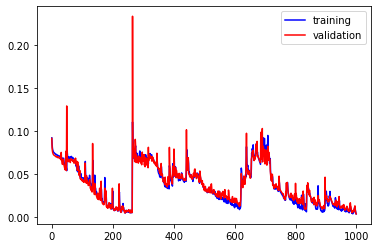

In [19]:
# Check for overfitting
plt.plot(fit.history['loss'], label='training', color='Blue')
plt.plot(fit.history['val_loss'], label='validation',color='Red')
plt.legend()
plt.show

## Performance

In [20]:
# Predictors and target for the testing set
testX, testY = test_scaled[:, 0:-1], test_scaled[:, -1]

In [21]:
# Build up state for forecasting
trainPred = model.predict(trainX)

10/10 [==============================] - 1s 26ms/step


In [22]:
testX[1]

array([[-0.73371105],
       [-0.64872521],
       [-0.60339943],
       [-0.70538244],
       [-0.63739377],
       [-0.38810198],
       [-0.28611898],
       [-0.4674221 ],
       [-0.52974504],
       [-0.62606232],
       [-0.83002833],
       [-0.45609065],
       [-0.43909348],
       [-0.76203966],
       [-0.52407932],
       [ 0.00283286],
       [-0.48441926],
       [-0.58640227],
       [-0.66005666],
       [-0.52974504],
       [-0.54674221],
       [-0.46175637],
       [-0.55240793],
       [-0.47308782],
       [-0.6203966 ],
       [-0.60339943],
       [-0.57507082],
       [-0.84135977],
       [-0.53541076],
       [-0.63172805],
       [-0.5694051 ],
       [-0.52407932],
       [-0.49575071],
       [-0.54107649],
       [-0.60906516],
       [-0.56373938],
       [-0.66572238],
       [-0.46175637],
       [-0.41643059],
       [-0.51274788],
       [-0.26912181],
       [-0.36543909],
       [-0.4674221 ],
       [-0.20113314],
       [ 0.00849858],
       [-0

In [25]:
# Walk-forward validation - one-step window 
predictions = list()
for i in range(0, test_scaled.shape[0]):
	yhat = model.predict(testX[i].reshape((1,60,1)))
	predictions.extend(yhat[0])

testPred = np.array(predictions)

1/1 [==============================] - 0s 36ms/step


In [26]:
# Convert the predictions back to the original scale
yTestHat = scaler.inverse_transform(np.array(predictions).reshape(-1,1))
yTest = scaler.inverse_transform(testY.reshape(-1,1))
yTrainHat = scaler.inverse_transform(trainPred.reshape(-1,1))
yTrain = scaler.inverse_transform(trainY.reshape(-1,1))

In [27]:
yTestHat

array([[ 0.02693056],
       [ 0.2272265 ],
       [-0.00239035],
       [ 0.60713387],
       [ 0.6827242 ],
       [ 0.38204178],
       [ 0.6786618 ],
       [ 0.19033735],
       [ 0.19843054],
       [ 0.09835927],
       [ 0.5147974 ],
       [ 0.29437768],
       [ 0.3224934 ],
       [ 0.8036051 ],
       [ 0.8853168 ],
       [ 0.840156  ],
       [ 1.0737578 ],
       [ 0.66373724],
       [ 0.8914214 ],
       [ 0.92756885],
       [ 0.57544625],
       [ 0.65608263],
       [ 0.52839226],
       [ 0.74823505],
       [ 0.6479085 ],
       [ 0.88068277],
       [ 1.6038604 ],
       [ 0.9306438 ],
       [ 0.7606063 ],
       [ 0.38167503],
       [ 0.60323477],
       [ 0.8091912 ],
       [ 0.58556795],
       [ 0.39085403],
       [ 0.69761544],
       [ 0.2365089 ]], dtype=float32)

In [28]:
# Performance as measured by the Root Mean Squared Error
trainScore = mean_squared_error(yTrain, yTrainHat[:,0])
print('Train Score: %.2f MSE' % (trainScore))
testScore = mean_squared_error(yTest, yTestHat[:,0])
print('Test Score: %.2f MSE' % (testScore))

model_error = yTest - yTestHat[:,0]
print('Mean Model Error: ', model_error.mean())

trace1 = go.Scatter(
                    x=df_lags[df_lags.index>'2019-08-01'].index,
                    y=df_lags[df_lags.index>'2019-08-01']['IPCA'].values,
                    name='Actual',
                    marker=dict(
                                color='SteelBlue'
                                )
                    )

trace2 = go.Scatter(
                    x=df_lags[df_lags.index>'2019-08-01'].index,
                    y=yTestHat.reshape(yTestHat.shape[0]),
                    name='Predicted',
                    marker=dict(
                                color='Firebrick'
                                )
                    )

fig = make_subplots(specs=[[{"secondary_y": False}]])
fig.add_trace(trace1)
fig.add_trace(trace2,secondary_y=False)
fig['layout'].update(
                    height=600,
                    width=800,
                    title='Actual vs Predicted',
                    xaxis=dict(
                              tickangle=-90
                              ),
                    showlegend=True,
                    )
iplot(fig)

Train Score: 0.01 MSE
Test Score: 0.23 MSE
Mean Model Error:  -0.03397756647758389


In [29]:
# Save the model
filePath = Path('./model_ZeroHidden_1000Epochs_120Neurons')
if filePath.exists():
    modelFile = input('./?')
else:
    modelFile = filePath

save_model(model, modelFile)

INFO:tensorflow:Assets written to: model_ZeroHidden_1000Epochs_120Neurons\assets


INFO:tensorflow:Assets written to: model_ZeroHidden_1000Epochs_120Neurons\assets


## Forecasting

In [34]:
# Load the model
model = load_model(modelFile, compile=True)

KeyboardInterrupt: 

In [30]:
# Preprocessing the input for the first period forecast
dataset = df_lags.drop(columns=['T-1'])
xInput = dataset.tail(1).values
xInput = scaler.transform(xInput.reshape(-1,1))

In [34]:
# Walk-forward forecast - one-step window - for the next 36 months 
for i in range(0, 36):
    x = xInput[-60:].reshape((1, 60, 1))
    output = model.predict(x)[0][0]
    xInput = np.append(xInput, [output])

1/1 [==============================] - 0s 51ms/step


In [35]:
# Reverse the scale
input = scaler.inverse_transform(xInput.reshape(-1,1))

In [36]:
# Consolidate the data
dfPred = pd.DataFrame(
                    input[-36:],
                    columns=['IPCA'],
                    index=pd.date_range('2022-09-01', periods=36, freq='M')
                    )

forecast = pd.concat([df, dfPred], ignore_index=False)
forecast

,IPCA
1995-01-01,1.700000
1995-02-01,1.020000
1995-03-01,1.550000
1995-04-01,2.430000
1995-05-01,2.670000
...,...
2025-04-30,0.298715
2025-05-31,0.397002
2025-06-30,0.156600
2025-07-31,0.168436


In [37]:
# The curves
trace21 = go.Scatter(
                    x=df[df.index>='2018-01-01'].index,
                    y=df.IPCA.values,
                    name='Actual',
                    marker=dict(
                                color='SteelBlue'
                                )
                    )

trace22 = go.Scatter(
                    x=dfPred.index,
                    y=dfPred.IPCA.values,
                    name='Forecast',
                    marker=dict(
                                color='Firebrick'
                                )
                    )

fig2 = make_subplots(specs=[[{"secondary_y": False}]])
fig2.add_trace(trace21)
fig2.add_trace(trace22,secondary_y=False)
fig2['layout'].update(
                      height=600,
                      width=800,
                      title='Actual vs Forecast',
                      xaxis=dict(
                                tickangle=-90
                                )
                    )
iplot(fig2)

In [38]:
# Using interpolation to convert the monthly data into daily samples
dailyForecast = forecast.resample('D').interpolate()
dailyForecast

,IPCA
1995-01-01,1.700000
1995-01-02,1.678065
1995-01-03,1.656129
1995-01-04,1.634194
1995-01-05,1.612258
...,...
2025-08-27,0.494716
2025-08-28,0.506800
2025-08-29,0.518885
2025-08-30,0.530969


In [69]:
# Daily Inflation Curve
trace31 = go.Scatter(
                    x=dailyForecast[
                                    (dailyForecast.index>'2010-01-01')
                                    & (dailyForecast.index<'2022-09-01')
                                    ].index,
                    y=dailyForecast[
                                    (dailyForecast.index>'2010-01-01')
                                    & (dailyForecast.index<'2022-09-01')                                    
                                    ].IPCA.values,
                    name='Actual',
                    marker=dict(
                                color='SteelBlue'
                                ),
                    )

trace32 = go.Scatter(
                    x=dailyForecast[dailyForecast.index>='2022-09-01'].index,
                    y=dailyForecast[
                                    dailyForecast.index>='2022-09-01'
                                    ].IPCA.values,
                    name='Forecast',
                    marker=dict(
                                color='Firebrick'
                                ),
                    )

fig3 = make_subplots(specs=[[{"secondary_y": False}]])
fig3.add_trace(trace31)
fig3.add_trace(trace32,secondary_y=False)
fig3.update(layout=layout,)
fig3['layout'].update(
                      height=800,
                      width=1000,
                      title='Daily Inflation Curve',
                      xaxis=dict(
                                tickangle=-90
                                )
                      )
iplot(fig3)

In [43]:
# Save a table
dailyForecast.to_excel(r'DailyInflation.xlsx')

## References
Almosova, A., & Andresen, N. (2019). Nonlinear Inflation Forecasting with Recurrent Neural Networks.  
Brownlee, J. (2017, April 7). Re: Time Series Forecasting with the Long Short-Term Memory Network in Python. Machine Learning Mastery. https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/  
Chakraborty, C., & Joseph, A. (2017). Machine learning at central banks.  
Garcia, M. G., Medeiros, M. C., & Vasconcelos, G. F. (2017). Real-time inflation forecasting with high-dimensional models: The case of Brazil. International Journal of Forecasting, 33(3), 679-693.  
Lazzeri, F. (2020). Machine learning for time series forecasting with Python. John Wiley & Sons.  
Medeiros, M. C., Vasconcelos, G. F., Veiga, Á., & Zilberman, E. (2021). Forecasting inflation in a data-rich environment: the benefits of machine learning methods. Journal of Business & Economic Statistics, 39(1), 98-119.  
Paranhos, L. (2021). Predicting inflation with neural networks. arXiv preprint arXiv:2104.03757.  
Schelter, B., Winterhalder, M., & Timmer, J. (2006). Handbook of time series analysis. Wiley-VCH, Berlin.  

